In [83]:
import warnings
warnings.filterwarnings('ignore')

## Importing required libraries

In [84]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from sklearn.linear_model import Lasso
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from scipy.stats import uniform 
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error  
from sklearn.metrics import r2_score
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import ParameterGrid
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam

## Data matrix generation & preprocessing (removing highly correlated features)

In [85]:
# X and y matrix generation
y_vec=pd.read_csv("aqsol data.txt",header=None)
Y=y_vec[1] #Target matrix ()
Y=np.array(Y)
x_vec=pd.read_csv("file1.csv",index_col=0)
X=x_vec.values
X=X[:,:-1] #feature matrix

In [86]:
print("total no of generated signature descriptors",len(x_vec.columns))
new_vec=x_vec.iloc[:,:-1]

total no of generated signature descriptors 3379


In [87]:
# function to remove features with more than 90 percent correlation
def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                if colname in dataset.columns:
                    del dataset[colname] # deleting the column from the dataset

    return(dataset)
uncor=correlation(new_vec,0.9)
X=uncor.values
X=X.astype(int)

In [88]:
print("total no of signature descriptors after removing feature with more than 90% correlation",len(uncor.columns))

total no of signature descriptors after removing feature with more than 90% correlation 1571


In [89]:
# Exploratory Data analysis 
print ("Statistics of the aqsol data:")
maxElement = np.amax(Y)
print('Maximum: ', maxElement)
minElement = np.amin(Y)
print('Minimum: ', minElement)
print ('Average:',np.average(Y))


Statistics of the aqsol data:
Maximum:  1.58
Minimum:  -11.6
Average: -3.0587655293088365


## Data Normalisation

In [90]:
Scaler= MinMaxScaler()
X_scaled=Scaler.fit_transform(X)

## L1 feature selection (Hyperparameter tuning using grid search)

In [91]:
param_grid = {'alpha': uniform()}
model = Lasso()
rand_search = RandomizedSearchCV(estimator=model, 
                                 param_distributions=param_grid,random_state=40,
                                n_iter=200)

rand_search.fit(X_scaled, Y)

print(rand_search.best_estimator_.alpha)
print(rand_search.best_score_)
best_alpha=rand_search.best_estimator_.alpha

0.0042243686391818525
0.8037845591191454


## Multiple Linear regression model

In [92]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=40)
scaling= MinMaxScaler()
X_train=scaling.fit_transform(X_train)
X_test=scaling.transform(X_test)

In [93]:
model_lasso = Lasso(alpha=best_alpha)
model_lasso.fit(X_train,y_train)
y_pred_train=model_lasso.predict(X_train)
y_pred_test=model_lasso.predict(X_test)
r2train= r2_score(y_train,y_pred_train)
r2test=r2_score(y_test,y_pred_test)

In [94]:
r2train,r2test

(0.8777022860095753, 0.8276239373798526)

In [95]:
print('Root mean squared error (test):',np.sqrt(mean_squared_error(y_test,y_pred_test)))
print('Root mean squared error (train):',np.sqrt(mean_squared_error(y_train,y_pred_train)))

Root mean squared error (test): 0.8227588507188169
Root mean squared error (train): 0.7426521532305829


## MLR Model performance 

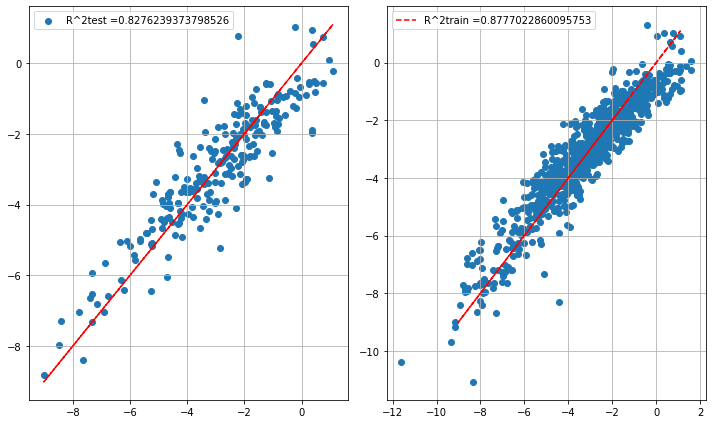

In [64]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].scatter(y_test, y_pred_test,label="R^2test ="+str(r2test))
axes[0].plot(y_test,y_test,'r--')
axes[0].legend()
axes[0].grid(True)
axes[1].scatter(y_train, y_pred_train)
axes[1].plot(y_test,y_test,'r--',label="R^2train ="+str(r2train))
axes[1].legend()
axes[1].grid(True)
fig.tight_layout()

In [65]:
from sklearn.metrics import mean_squared_error
print("RMSE on train set",mean_squared_error(y_train,y_pred_train))
print("RMSE on train set",mean_squared_error(y_test,y_pred_test))

RMSE on train set 0.5515322206980212
RMSE on train set 0.6769321264361485


## Feature selection and significance (Parameter sensitivity)

In [66]:
coeff = model_lasso.coef_
a=[]
for i in range(len(coeff)):
    if(coeff[i]!=0):
        a.append(i)
XNN=X[:,a]
print(" No of Signature descriptors selected using L1 feature selection method:",len(XNN[0]))

 No of Signature descriptors selected using L1 feature selection method: 83


In [67]:
dict={'weights':coeff[a].astype(float),'descriptor':uncor.columns[a]}
new_df=pd.DataFrame(data=dict)


In [103]:
new_df.sort_values(by= [new_df.columns[0]],axis=0, ascending=True, inplace=True)
print(new_df.head(12))
print("\n")
print(new_df.tail(11))

     weights                descriptor
1  -7.288989                       [C]
0  -5.702998                      [Cl]
9  -3.243925     [C]([C]([C])[C]([C]))
4  -3.157147                   [C]=[C]
11 -2.818981                      [Br]
8  -2.283436  [C]([C]=[C])[C]([C]=[C])
7  -1.813920               [C]([C][C])
62 -1.813215                   [P]=[S]
17 -1.653292           [N]([C][O]=[O])
41 -1.627357                       [I]
21 -1.532294                       [S]
6  -1.293141          [C]([C]=[C][Cl])


     weights                descriptor
31  0.536141                   [C]=[O]
28  0.541980    [C]([C])[C]([C][C][O])
38  0.546411          [C]([C])[C]([O])
19  0.555033         [C](\=\[C][C])[O]
64  0.706211                   [O]=[P]
40  0.733317  [C]([C]([C])[C]([C][O]))
56  0.774112    [C](\=/[C])[C](\=/[N])
51  0.812611       [C]([C])\=/[N]([C])
52  1.197925    [C]([C])\=/[C]([C][N])
14  2.160589                  [O]([C])
5   2.564086                       [O]


## Regularised Neural Network Model 

In [69]:
X_train, X_test, y_train, y_test = train_test_split(XNN, Y, test_size=0.20, random_state=40)
scaling= MinMaxScaler()
X_train=scaling.fit_transform(X_train)
X_test=scaling.transform(X_test)

In [70]:
#baseline model
baseline_model = Sequential([
  Dense(len(X_train[0]), activation='relu'),
  Dense(8, activation='relu'),
  Dense(1,activation='linear')])
# Compile the model.
baseline_model.compile(optimizer='adam',loss='mean_squared_error')
# Train the model.
history = baseline_model.fit(
  X_train,
  y_train,
  epochs=100,
  validation_data = (X_test,y_test)
)

Train on 914 samples, validate on 229 samples
Epoch 1/100
914/914 [==============================] - 0s 322us/sample - loss: 11.9877 - val_loss: 8.6024
Epoch 2/100
914/914 [==============================] - 0s 60us/sample - loss: 7.4315 - val_loss: 4.4450
Epoch 3/100
914/914 [==============================] - 0s 59us/sample - loss: 3.8785 - val_loss: 2.6739
Epoch 4/100
914/914 [==============================] - 0s 58us/sample - loss: 2.6203 - val_loss: 1.9925
Epoch 5/100
914/914 [==============================] - 0s 56us/sample - loss: 1.9120 - val_loss: 1.5232
Epoch 6/100
914/914 [==============================] - 0s 55us/sample - loss: 1.4006 - val_loss: 1.2303
Epoch 7/100
914/914 [==============================] - 0s 56us/sample - loss: 1.0677 - val_loss: 1.0339
Epoch 8/100
914/914 [==============================] - 0s 59us/sample - loss: 0.8397 - val_loss: 0.9149
Epoch 9/100
914/914 [==============================] - 0s 63us/sample - loss: 0.6914 - val_loss: 0.8277
Epoch 10/100
914

In [71]:
#performance of baseline model
Y_pred=baseline_model.predict(X_test)
from sklearn.metrics import r2_score
print('R squared (test set):',r2_score(y_test,Y_pred))
print('Mean squared error (test set):',mean_squared_error(y_test,Y_pred))


R squared (test set): 0.8457515770354711
Mean squared error (test set): 0.6057436941630017


## Hyperparameter tuning of the neural network model to improve model performance

In [72]:
#defining callback to save the best model during training
def model_callbacks(weight_file='Weights_v3{epoch:02d}.h5'):  
    checkpoint = ModelCheckpoint(weight_file, monitor = 'val_loss', verbose=1, save_best_only= True,save_weights_only= True, mode = 'min')
    #checkpoint = ModelCheckpoint(weight_file, monitor = 'val_loss', verbose=1)
    return [checkpoint]
#defining function to grid search best hyperparameter for learning rate and batch_size
def my_nn_model(alpha=0.001):
    model = Sequential([
    Dense(len(X_train[0]), activation='relu',activity_regularizer = regularizers.l2(1e-3)),
    Dropout(0.2),
    Dense(8, activation='relu',activity_regularizer = regularizers.l2(1e-4)),
    Dropout(0.01),
    Dense(1,activation='linear')])
    model.compile(optimizer=Adam(learning_rate=alpha),loss='mean_squared_error')
    return model

In [74]:
#searching for the best hyperparameter and saving the weights of the best model
step_size_list = [0.0001,0.001,1e-1,1e-2]
batch_size_list = [16,32,64,128]
param_grid = {'step_size': step_size_list,'batch_size': batch_size_list}
grid_search = list(ParameterGrid(param_grid))
val_loss = []
for index,item in enumerate(grid_search):
    test_model = my_nn_model(item['step_size'])
    weight_file='Weights_gs'+str(index)+'{epoch:02d}.h5'
    history = test_model.fit(X_train,y_train,epochs=500,batch_size=item['batch_size'],validation_data = (X_test,y_test),callbacks=model_callbacks(weight_file),verbose=0)
    val_loss.append(min(history.history['val_loss']))



Epoch 00001: val_loss improved from inf to 12.93852, saving model to Weights_gs001.h5

Epoch 00002: val_loss improved from 12.93852 to 12.47231, saving model to Weights_gs002.h5

Epoch 00003: val_loss improved from 12.47231 to 11.90266, saving model to Weights_gs003.h5

Epoch 00004: val_loss improved from 11.90266 to 11.12296, saving model to Weights_gs004.h5

Epoch 00005: val_loss improved from 11.12296 to 10.22895, saving model to Weights_gs005.h5

Epoch 00006: val_loss improved from 10.22895 to 9.34664, saving model to Weights_gs006.h5

Epoch 00007: val_loss improved from 9.34664 to 8.47093, saving model to Weights_gs007.h5

Epoch 00008: val_loss improved from 8.47093 to 7.60100, saving model to Weights_gs008.h5

Epoch 00009: val_loss improved from 7.60100 to 6.73494, saving model to Weights_gs009.h5

Epoch 00010: val_loss improved from 6.73494 to 5.91200, saving model to Weights_gs010.h5

Epoch 00011: val_loss improved from 5.91200 to 5.16066, saving model to Weights_gs011.h5

Epo


Epoch 00095: val_loss did not improve from 0.65587

Epoch 00096: val_loss did not improve from 0.65587

Epoch 00097: val_loss improved from 0.65587 to 0.65584, saving model to Weights_gs097.h5

Epoch 00098: val_loss improved from 0.65584 to 0.65453, saving model to Weights_gs098.h5

Epoch 00099: val_loss improved from 0.65453 to 0.65444, saving model to Weights_gs099.h5

Epoch 00100: val_loss improved from 0.65444 to 0.65198, saving model to Weights_gs0100.h5

Epoch 00101: val_loss improved from 0.65198 to 0.65114, saving model to Weights_gs0101.h5

Epoch 00102: val_loss did not improve from 0.65114

Epoch 00103: val_loss improved from 0.65114 to 0.64688, saving model to Weights_gs0103.h5

Epoch 00104: val_loss improved from 0.64688 to 0.64666, saving model to Weights_gs0104.h5

Epoch 00105: val_loss improved from 0.64666 to 0.64516, saving model to Weights_gs0105.h5

Epoch 00106: val_loss improved from 0.64516 to 0.64379, saving model to Weights_gs0106.h5

Epoch 00107: val_loss impro


Epoch 00217: val_loss improved from 0.59235 to 0.59196, saving model to Weights_gs0217.h5

Epoch 00218: val_loss did not improve from 0.59196

Epoch 00219: val_loss did not improve from 0.59196

Epoch 00220: val_loss did not improve from 0.59196

Epoch 00221: val_loss improved from 0.59196 to 0.59166, saving model to Weights_gs0221.h5

Epoch 00222: val_loss did not improve from 0.59166

Epoch 00223: val_loss did not improve from 0.59166

Epoch 00224: val_loss did not improve from 0.59166

Epoch 00225: val_loss did not improve from 0.59166

Epoch 00226: val_loss did not improve from 0.59166

Epoch 00227: val_loss did not improve from 0.59166

Epoch 00228: val_loss did not improve from 0.59166

Epoch 00229: val_loss did not improve from 0.59166

Epoch 00230: val_loss did not improve from 0.59166

Epoch 00231: val_loss did not improve from 0.59166

Epoch 00232: val_loss did not improve from 0.59166

Epoch 00233: val_loss did not improve from 0.59166

Epoch 00234: val_loss did not improve


Epoch 00359: val_loss did not improve from 0.57043

Epoch 00360: val_loss did not improve from 0.57043

Epoch 00361: val_loss did not improve from 0.57043

Epoch 00362: val_loss did not improve from 0.57043

Epoch 00363: val_loss did not improve from 0.57043

Epoch 00364: val_loss did not improve from 0.57043

Epoch 00365: val_loss did not improve from 0.57043

Epoch 00366: val_loss did not improve from 0.57043

Epoch 00367: val_loss did not improve from 0.57043

Epoch 00368: val_loss did not improve from 0.57043

Epoch 00369: val_loss did not improve from 0.57043

Epoch 00370: val_loss did not improve from 0.57043

Epoch 00371: val_loss did not improve from 0.57043

Epoch 00372: val_loss did not improve from 0.57043

Epoch 00373: val_loss did not improve from 0.57043

Epoch 00374: val_loss did not improve from 0.57043

Epoch 00375: val_loss did not improve from 0.57043

Epoch 00376: val_loss did not improve from 0.57043

Epoch 00377: val_loss did not improve from 0.57043

Epoch 00378


Epoch 00008: val_loss improved from 0.73765 to 0.69784, saving model to Weights_gs108.h5

Epoch 00009: val_loss improved from 0.69784 to 0.68078, saving model to Weights_gs109.h5

Epoch 00010: val_loss improved from 0.68078 to 0.66699, saving model to Weights_gs110.h5

Epoch 00011: val_loss improved from 0.66699 to 0.66002, saving model to Weights_gs111.h5

Epoch 00012: val_loss improved from 0.66002 to 0.64363, saving model to Weights_gs112.h5

Epoch 00013: val_loss improved from 0.64363 to 0.63297, saving model to Weights_gs113.h5

Epoch 00014: val_loss improved from 0.63297 to 0.63039, saving model to Weights_gs114.h5

Epoch 00015: val_loss improved from 0.63039 to 0.62300, saving model to Weights_gs115.h5

Epoch 00016: val_loss improved from 0.62300 to 0.61650, saving model to Weights_gs116.h5

Epoch 00017: val_loss did not improve from 0.61650

Epoch 00018: val_loss improved from 0.61650 to 0.61336, saving model to Weights_gs118.h5

Epoch 00019: val_loss did not improve from 0.61


Epoch 00149: val_loss did not improve from 0.51735

Epoch 00150: val_loss did not improve from 0.51735

Epoch 00151: val_loss did not improve from 0.51735

Epoch 00152: val_loss did not improve from 0.51735

Epoch 00153: val_loss did not improve from 0.51735

Epoch 00154: val_loss did not improve from 0.51735

Epoch 00155: val_loss did not improve from 0.51735

Epoch 00156: val_loss did not improve from 0.51735

Epoch 00157: val_loss did not improve from 0.51735

Epoch 00158: val_loss did not improve from 0.51735

Epoch 00159: val_loss did not improve from 0.51735

Epoch 00160: val_loss did not improve from 0.51735

Epoch 00161: val_loss did not improve from 0.51735

Epoch 00162: val_loss did not improve from 0.51735

Epoch 00163: val_loss did not improve from 0.51735

Epoch 00164: val_loss did not improve from 0.51735

Epoch 00165: val_loss did not improve from 0.51735

Epoch 00166: val_loss did not improve from 0.51735

Epoch 00167: val_loss did not improve from 0.51735

Epoch 00168


Epoch 00308: val_loss did not improve from 0.51735

Epoch 00309: val_loss did not improve from 0.51735

Epoch 00310: val_loss did not improve from 0.51735

Epoch 00311: val_loss did not improve from 0.51735

Epoch 00312: val_loss did not improve from 0.51735

Epoch 00313: val_loss did not improve from 0.51735

Epoch 00314: val_loss did not improve from 0.51735

Epoch 00315: val_loss did not improve from 0.51735

Epoch 00316: val_loss did not improve from 0.51735

Epoch 00317: val_loss did not improve from 0.51735

Epoch 00318: val_loss did not improve from 0.51735

Epoch 00319: val_loss did not improve from 0.51735

Epoch 00320: val_loss did not improve from 0.51735

Epoch 00321: val_loss did not improve from 0.51735

Epoch 00322: val_loss did not improve from 0.51735

Epoch 00323: val_loss did not improve from 0.51735

Epoch 00324: val_loss did not improve from 0.51735

Epoch 00325: val_loss did not improve from 0.51735

Epoch 00326: val_loss did not improve from 0.51735

Epoch 00327


Epoch 00468: val_loss did not improve from 0.51735

Epoch 00469: val_loss did not improve from 0.51735

Epoch 00470: val_loss did not improve from 0.51735

Epoch 00471: val_loss did not improve from 0.51735

Epoch 00472: val_loss did not improve from 0.51735

Epoch 00473: val_loss did not improve from 0.51735

Epoch 00474: val_loss did not improve from 0.51735

Epoch 00475: val_loss did not improve from 0.51735

Epoch 00476: val_loss did not improve from 0.51735

Epoch 00477: val_loss did not improve from 0.51735

Epoch 00478: val_loss did not improve from 0.51735

Epoch 00479: val_loss did not improve from 0.51735

Epoch 00480: val_loss did not improve from 0.51735

Epoch 00481: val_loss did not improve from 0.51735

Epoch 00482: val_loss did not improve from 0.51735

Epoch 00483: val_loss did not improve from 0.51735

Epoch 00484: val_loss did not improve from 0.51735

Epoch 00485: val_loss did not improve from 0.51735

Epoch 00486: val_loss did not improve from 0.51735

Epoch 00487


Epoch 00123: val_loss did not improve from 0.66042

Epoch 00124: val_loss did not improve from 0.66042

Epoch 00125: val_loss did not improve from 0.66042

Epoch 00126: val_loss did not improve from 0.66042

Epoch 00127: val_loss did not improve from 0.66042

Epoch 00128: val_loss did not improve from 0.66042

Epoch 00129: val_loss did not improve from 0.66042

Epoch 00130: val_loss did not improve from 0.66042

Epoch 00131: val_loss did not improve from 0.66042

Epoch 00132: val_loss did not improve from 0.66042

Epoch 00133: val_loss did not improve from 0.66042

Epoch 00134: val_loss did not improve from 0.66042

Epoch 00135: val_loss did not improve from 0.66042

Epoch 00136: val_loss did not improve from 0.66042

Epoch 00137: val_loss did not improve from 0.66042

Epoch 00138: val_loss did not improve from 0.66042

Epoch 00139: val_loss did not improve from 0.66042

Epoch 00140: val_loss did not improve from 0.66042

Epoch 00141: val_loss did not improve from 0.66042

Epoch 00142


Epoch 00281: val_loss did not improve from 0.66042

Epoch 00282: val_loss did not improve from 0.66042

Epoch 00283: val_loss did not improve from 0.66042

Epoch 00284: val_loss did not improve from 0.66042

Epoch 00285: val_loss did not improve from 0.66042

Epoch 00286: val_loss did not improve from 0.66042

Epoch 00287: val_loss did not improve from 0.66042

Epoch 00288: val_loss did not improve from 0.66042

Epoch 00289: val_loss did not improve from 0.66042

Epoch 00290: val_loss did not improve from 0.66042

Epoch 00291: val_loss did not improve from 0.66042

Epoch 00292: val_loss did not improve from 0.66042

Epoch 00293: val_loss did not improve from 0.66042

Epoch 00294: val_loss did not improve from 0.66042

Epoch 00295: val_loss did not improve from 0.66042

Epoch 00296: val_loss did not improve from 0.66042

Epoch 00297: val_loss did not improve from 0.66042

Epoch 00298: val_loss did not improve from 0.66042

Epoch 00299: val_loss did not improve from 0.66042

Epoch 00300


Epoch 00440: val_loss did not improve from 0.66042

Epoch 00441: val_loss did not improve from 0.66042

Epoch 00442: val_loss did not improve from 0.66042

Epoch 00443: val_loss did not improve from 0.66042

Epoch 00444: val_loss did not improve from 0.66042

Epoch 00445: val_loss did not improve from 0.66042

Epoch 00446: val_loss did not improve from 0.66042

Epoch 00447: val_loss did not improve from 0.66042

Epoch 00448: val_loss did not improve from 0.66042

Epoch 00449: val_loss did not improve from 0.66042

Epoch 00450: val_loss did not improve from 0.66042

Epoch 00451: val_loss did not improve from 0.66042

Epoch 00452: val_loss did not improve from 0.66042

Epoch 00453: val_loss did not improve from 0.66042

Epoch 00454: val_loss did not improve from 0.66042

Epoch 00455: val_loss did not improve from 0.66042

Epoch 00456: val_loss did not improve from 0.66042

Epoch 00457: val_loss did not improve from 0.66042

Epoch 00458: val_loss did not improve from 0.66042

Epoch 00459


Epoch 00089: val_loss did not improve from 0.58705

Epoch 00090: val_loss did not improve from 0.58705

Epoch 00091: val_loss did not improve from 0.58705

Epoch 00092: val_loss did not improve from 0.58705

Epoch 00093: val_loss did not improve from 0.58705

Epoch 00094: val_loss did not improve from 0.58705

Epoch 00095: val_loss did not improve from 0.58705

Epoch 00096: val_loss did not improve from 0.58705

Epoch 00097: val_loss did not improve from 0.58705

Epoch 00098: val_loss did not improve from 0.58705

Epoch 00099: val_loss did not improve from 0.58705

Epoch 00100: val_loss did not improve from 0.58705

Epoch 00101: val_loss did not improve from 0.58705

Epoch 00102: val_loss did not improve from 0.58705

Epoch 00103: val_loss did not improve from 0.58705

Epoch 00104: val_loss did not improve from 0.58705

Epoch 00105: val_loss did not improve from 0.58705

Epoch 00106: val_loss did not improve from 0.58705

Epoch 00107: val_loss did not improve from 0.58705

Epoch 00108


Epoch 00248: val_loss did not improve from 0.58705

Epoch 00249: val_loss did not improve from 0.58705

Epoch 00250: val_loss did not improve from 0.58705

Epoch 00251: val_loss did not improve from 0.58705

Epoch 00252: val_loss did not improve from 0.58705

Epoch 00253: val_loss did not improve from 0.58705

Epoch 00254: val_loss did not improve from 0.58705

Epoch 00255: val_loss did not improve from 0.58705

Epoch 00256: val_loss did not improve from 0.58705

Epoch 00257: val_loss did not improve from 0.58705

Epoch 00258: val_loss did not improve from 0.58705

Epoch 00259: val_loss did not improve from 0.58705

Epoch 00260: val_loss did not improve from 0.58705

Epoch 00261: val_loss did not improve from 0.58705

Epoch 00262: val_loss did not improve from 0.58705

Epoch 00263: val_loss did not improve from 0.58705

Epoch 00264: val_loss did not improve from 0.58705

Epoch 00265: val_loss did not improve from 0.58705

Epoch 00266: val_loss did not improve from 0.58705

Epoch 00267


Epoch 00406: val_loss did not improve from 0.58705

Epoch 00407: val_loss did not improve from 0.58705

Epoch 00408: val_loss did not improve from 0.58705

Epoch 00409: val_loss did not improve from 0.58705

Epoch 00410: val_loss did not improve from 0.58705

Epoch 00411: val_loss did not improve from 0.58705

Epoch 00412: val_loss did not improve from 0.58705

Epoch 00413: val_loss did not improve from 0.58705

Epoch 00414: val_loss did not improve from 0.58705

Epoch 00415: val_loss did not improve from 0.58705

Epoch 00416: val_loss did not improve from 0.58705

Epoch 00417: val_loss did not improve from 0.58705

Epoch 00418: val_loss did not improve from 0.58705

Epoch 00419: val_loss did not improve from 0.58705

Epoch 00420: val_loss did not improve from 0.58705

Epoch 00421: val_loss did not improve from 0.58705

Epoch 00422: val_loss did not improve from 0.58705

Epoch 00423: val_loss did not improve from 0.58705

Epoch 00424: val_loss did not improve from 0.58705

Epoch 00425


Epoch 00038: val_loss improved from 2.21564 to 2.16086, saving model to Weights_gs438.h5

Epoch 00039: val_loss improved from 2.16086 to 2.10967, saving model to Weights_gs439.h5

Epoch 00040: val_loss improved from 2.10967 to 2.05648, saving model to Weights_gs440.h5

Epoch 00041: val_loss improved from 2.05648 to 2.00654, saving model to Weights_gs441.h5

Epoch 00042: val_loss improved from 2.00654 to 1.95584, saving model to Weights_gs442.h5

Epoch 00043: val_loss improved from 1.95584 to 1.90824, saving model to Weights_gs443.h5

Epoch 00044: val_loss improved from 1.90824 to 1.86202, saving model to Weights_gs444.h5

Epoch 00045: val_loss improved from 1.86202 to 1.81685, saving model to Weights_gs445.h5

Epoch 00046: val_loss improved from 1.81685 to 1.77331, saving model to Weights_gs446.h5

Epoch 00047: val_loss improved from 1.77331 to 1.73176, saving model to Weights_gs447.h5

Epoch 00048: val_loss improved from 1.73176 to 1.68986, saving model to Weights_gs448.h5

Epoch 000


Epoch 00129: val_loss improved from 0.69911 to 0.69543, saving model to Weights_gs4129.h5

Epoch 00130: val_loss improved from 0.69543 to 0.69383, saving model to Weights_gs4130.h5

Epoch 00131: val_loss improved from 0.69383 to 0.69121, saving model to Weights_gs4131.h5

Epoch 00132: val_loss improved from 0.69121 to 0.68940, saving model to Weights_gs4132.h5

Epoch 00133: val_loss improved from 0.68940 to 0.68809, saving model to Weights_gs4133.h5

Epoch 00134: val_loss improved from 0.68809 to 0.68625, saving model to Weights_gs4134.h5

Epoch 00135: val_loss improved from 0.68625 to 0.68413, saving model to Weights_gs4135.h5

Epoch 00136: val_loss improved from 0.68413 to 0.68169, saving model to Weights_gs4136.h5

Epoch 00137: val_loss improved from 0.68169 to 0.67970, saving model to Weights_gs4137.h5

Epoch 00138: val_loss improved from 0.67970 to 0.67805, saving model to Weights_gs4138.h5

Epoch 00139: val_loss improved from 0.67805 to 0.67688, saving model to Weights_gs4139.h5


Epoch 00238: val_loss improved from 0.61382 to 0.61206, saving model to Weights_gs4238.h5

Epoch 00239: val_loss did not improve from 0.61206

Epoch 00240: val_loss did not improve from 0.61206

Epoch 00241: val_loss did not improve from 0.61206

Epoch 00242: val_loss did not improve from 0.61206

Epoch 00243: val_loss did not improve from 0.61206

Epoch 00244: val_loss did not improve from 0.61206

Epoch 00245: val_loss improved from 0.61206 to 0.61159, saving model to Weights_gs4245.h5

Epoch 00246: val_loss did not improve from 0.61159

Epoch 00247: val_loss did not improve from 0.61159

Epoch 00248: val_loss improved from 0.61159 to 0.60963, saving model to Weights_gs4248.h5

Epoch 00249: val_loss improved from 0.60963 to 0.60959, saving model to Weights_gs4249.h5

Epoch 00250: val_loss improved from 0.60959 to 0.60959, saving model to Weights_gs4250.h5

Epoch 00251: val_loss did not improve from 0.60959

Epoch 00252: val_loss did not improve from 0.60959

Epoch 00253: val_loss im


Epoch 00379: val_loss did not improve from 0.59648

Epoch 00380: val_loss improved from 0.59648 to 0.59610, saving model to Weights_gs4380.h5

Epoch 00381: val_loss improved from 0.59610 to 0.59541, saving model to Weights_gs4381.h5

Epoch 00382: val_loss did not improve from 0.59541

Epoch 00383: val_loss improved from 0.59541 to 0.59509, saving model to Weights_gs4383.h5

Epoch 00384: val_loss did not improve from 0.59509

Epoch 00385: val_loss did not improve from 0.59509

Epoch 00386: val_loss did not improve from 0.59509

Epoch 00387: val_loss did not improve from 0.59509

Epoch 00388: val_loss did not improve from 0.59509

Epoch 00389: val_loss did not improve from 0.59509

Epoch 00390: val_loss did not improve from 0.59509

Epoch 00391: val_loss improved from 0.59509 to 0.59398, saving model to Weights_gs4391.h5

Epoch 00392: val_loss improved from 0.59398 to 0.59340, saving model to Weights_gs4392.h5

Epoch 00393: val_loss did not improve from 0.59340

Epoch 00394: val_loss di


Epoch 00020: val_loss did not improve from 0.63061

Epoch 00021: val_loss did not improve from 0.63061

Epoch 00022: val_loss did not improve from 0.63061

Epoch 00023: val_loss did not improve from 0.63061

Epoch 00024: val_loss improved from 0.63061 to 0.63048, saving model to Weights_gs524.h5

Epoch 00025: val_loss improved from 0.63048 to 0.62911, saving model to Weights_gs525.h5

Epoch 00026: val_loss did not improve from 0.62911

Epoch 00027: val_loss improved from 0.62911 to 0.62870, saving model to Weights_gs527.h5

Epoch 00028: val_loss did not improve from 0.62870

Epoch 00029: val_loss did not improve from 0.62870

Epoch 00030: val_loss improved from 0.62870 to 0.61552, saving model to Weights_gs530.h5

Epoch 00031: val_loss improved from 0.61552 to 0.61050, saving model to Weights_gs531.h5

Epoch 00032: val_loss did not improve from 0.61050

Epoch 00033: val_loss did not improve from 0.61050

Epoch 00034: val_loss did not improve from 0.61050

Epoch 00035: val_loss did not


Epoch 00162: val_loss improved from 0.55495 to 0.55078, saving model to Weights_gs5162.h5

Epoch 00163: val_loss did not improve from 0.55078

Epoch 00164: val_loss did not improve from 0.55078

Epoch 00165: val_loss did not improve from 0.55078

Epoch 00166: val_loss did not improve from 0.55078

Epoch 00167: val_loss did not improve from 0.55078

Epoch 00168: val_loss did not improve from 0.55078

Epoch 00169: val_loss did not improve from 0.55078

Epoch 00170: val_loss did not improve from 0.55078

Epoch 00171: val_loss did not improve from 0.55078

Epoch 00172: val_loss did not improve from 0.55078

Epoch 00173: val_loss did not improve from 0.55078

Epoch 00174: val_loss did not improve from 0.55078

Epoch 00175: val_loss did not improve from 0.55078

Epoch 00176: val_loss did not improve from 0.55078

Epoch 00177: val_loss improved from 0.55078 to 0.54922, saving model to Weights_gs5177.h5

Epoch 00178: val_loss did not improve from 0.54922

Epoch 00179: val_loss did not improve


Epoch 00319: val_loss did not improve from 0.54922

Epoch 00320: val_loss did not improve from 0.54922

Epoch 00321: val_loss did not improve from 0.54922

Epoch 00322: val_loss did not improve from 0.54922

Epoch 00323: val_loss did not improve from 0.54922

Epoch 00324: val_loss did not improve from 0.54922

Epoch 00325: val_loss did not improve from 0.54922

Epoch 00326: val_loss did not improve from 0.54922

Epoch 00327: val_loss did not improve from 0.54922

Epoch 00328: val_loss did not improve from 0.54922

Epoch 00329: val_loss did not improve from 0.54922

Epoch 00330: val_loss did not improve from 0.54922

Epoch 00331: val_loss did not improve from 0.54922

Epoch 00332: val_loss did not improve from 0.54922

Epoch 00333: val_loss did not improve from 0.54922

Epoch 00334: val_loss did not improve from 0.54922

Epoch 00335: val_loss did not improve from 0.54922

Epoch 00336: val_loss did not improve from 0.54922

Epoch 00337: val_loss did not improve from 0.54922

Epoch 00338


Epoch 00480: val_loss did not improve from 0.54922

Epoch 00481: val_loss did not improve from 0.54922

Epoch 00482: val_loss did not improve from 0.54922

Epoch 00483: val_loss did not improve from 0.54922

Epoch 00484: val_loss did not improve from 0.54922

Epoch 00485: val_loss did not improve from 0.54922

Epoch 00486: val_loss did not improve from 0.54922

Epoch 00487: val_loss did not improve from 0.54922

Epoch 00488: val_loss did not improve from 0.54922

Epoch 00489: val_loss did not improve from 0.54922

Epoch 00490: val_loss did not improve from 0.54922

Epoch 00491: val_loss did not improve from 0.54922

Epoch 00492: val_loss did not improve from 0.54922

Epoch 00493: val_loss did not improve from 0.54922

Epoch 00494: val_loss did not improve from 0.54922

Epoch 00495: val_loss did not improve from 0.54922

Epoch 00496: val_loss did not improve from 0.54922

Epoch 00497: val_loss did not improve from 0.54922

Epoch 00498: val_loss did not improve from 0.54922

Epoch 00499


Epoch 00134: val_loss did not improve from 0.63323

Epoch 00135: val_loss did not improve from 0.63323

Epoch 00136: val_loss did not improve from 0.63323

Epoch 00137: val_loss did not improve from 0.63323

Epoch 00138: val_loss did not improve from 0.63323

Epoch 00139: val_loss did not improve from 0.63323

Epoch 00140: val_loss did not improve from 0.63323

Epoch 00141: val_loss did not improve from 0.63323

Epoch 00142: val_loss did not improve from 0.63323

Epoch 00143: val_loss did not improve from 0.63323

Epoch 00144: val_loss did not improve from 0.63323

Epoch 00145: val_loss did not improve from 0.63323

Epoch 00146: val_loss did not improve from 0.63323

Epoch 00147: val_loss did not improve from 0.63323

Epoch 00148: val_loss did not improve from 0.63323

Epoch 00149: val_loss did not improve from 0.63323

Epoch 00150: val_loss did not improve from 0.63323

Epoch 00151: val_loss did not improve from 0.63323

Epoch 00152: val_loss did not improve from 0.63323

Epoch 00153


Epoch 00293: val_loss did not improve from 0.63323

Epoch 00294: val_loss did not improve from 0.63323

Epoch 00295: val_loss did not improve from 0.63323

Epoch 00296: val_loss did not improve from 0.63323

Epoch 00297: val_loss did not improve from 0.63323

Epoch 00298: val_loss did not improve from 0.63323

Epoch 00299: val_loss did not improve from 0.63323

Epoch 00300: val_loss did not improve from 0.63323

Epoch 00301: val_loss did not improve from 0.63323

Epoch 00302: val_loss did not improve from 0.63323

Epoch 00303: val_loss did not improve from 0.63323

Epoch 00304: val_loss did not improve from 0.63323

Epoch 00305: val_loss did not improve from 0.63323

Epoch 00306: val_loss did not improve from 0.63323

Epoch 00307: val_loss did not improve from 0.63323

Epoch 00308: val_loss did not improve from 0.63323

Epoch 00309: val_loss did not improve from 0.63323

Epoch 00310: val_loss did not improve from 0.63323

Epoch 00311: val_loss did not improve from 0.63323

Epoch 00312


Epoch 00453: val_loss did not improve from 0.63323

Epoch 00454: val_loss did not improve from 0.63323

Epoch 00455: val_loss did not improve from 0.63323

Epoch 00456: val_loss did not improve from 0.63323

Epoch 00457: val_loss did not improve from 0.63323

Epoch 00458: val_loss did not improve from 0.63323

Epoch 00459: val_loss did not improve from 0.63323

Epoch 00460: val_loss did not improve from 0.63323

Epoch 00461: val_loss did not improve from 0.63323

Epoch 00462: val_loss did not improve from 0.63323

Epoch 00463: val_loss did not improve from 0.63323

Epoch 00464: val_loss did not improve from 0.63323

Epoch 00465: val_loss did not improve from 0.63323

Epoch 00466: val_loss did not improve from 0.63323

Epoch 00467: val_loss did not improve from 0.63323

Epoch 00468: val_loss did not improve from 0.63323

Epoch 00469: val_loss did not improve from 0.63323

Epoch 00470: val_loss did not improve from 0.63323

Epoch 00471: val_loss did not improve from 0.63323

Epoch 00472


Epoch 00104: val_loss did not improve from 0.55939

Epoch 00105: val_loss did not improve from 0.55939

Epoch 00106: val_loss did not improve from 0.55939

Epoch 00107: val_loss did not improve from 0.55939

Epoch 00108: val_loss did not improve from 0.55939

Epoch 00109: val_loss did not improve from 0.55939

Epoch 00110: val_loss did not improve from 0.55939

Epoch 00111: val_loss did not improve from 0.55939

Epoch 00112: val_loss did not improve from 0.55939

Epoch 00113: val_loss did not improve from 0.55939

Epoch 00114: val_loss did not improve from 0.55939

Epoch 00115: val_loss did not improve from 0.55939

Epoch 00116: val_loss did not improve from 0.55939

Epoch 00117: val_loss did not improve from 0.55939

Epoch 00118: val_loss did not improve from 0.55939

Epoch 00119: val_loss did not improve from 0.55939

Epoch 00120: val_loss did not improve from 0.55939

Epoch 00121: val_loss did not improve from 0.55939

Epoch 00122: val_loss did not improve from 0.55939

Epoch 00123


Epoch 00263: val_loss did not improve from 0.55939

Epoch 00264: val_loss did not improve from 0.55939

Epoch 00265: val_loss did not improve from 0.55939

Epoch 00266: val_loss did not improve from 0.55939

Epoch 00267: val_loss did not improve from 0.55939

Epoch 00268: val_loss did not improve from 0.55939

Epoch 00269: val_loss did not improve from 0.55939

Epoch 00270: val_loss did not improve from 0.55939

Epoch 00271: val_loss did not improve from 0.55939

Epoch 00272: val_loss did not improve from 0.55939

Epoch 00273: val_loss did not improve from 0.55939

Epoch 00274: val_loss did not improve from 0.55939

Epoch 00275: val_loss did not improve from 0.55939

Epoch 00276: val_loss did not improve from 0.55939

Epoch 00277: val_loss did not improve from 0.55939

Epoch 00278: val_loss did not improve from 0.55939

Epoch 00279: val_loss did not improve from 0.55939

Epoch 00280: val_loss did not improve from 0.55939

Epoch 00281: val_loss did not improve from 0.55939

Epoch 00282


Epoch 00424: val_loss did not improve from 0.55939

Epoch 00425: val_loss did not improve from 0.55939

Epoch 00426: val_loss did not improve from 0.55939

Epoch 00427: val_loss did not improve from 0.55939

Epoch 00428: val_loss did not improve from 0.55939

Epoch 00429: val_loss did not improve from 0.55939

Epoch 00430: val_loss did not improve from 0.55939

Epoch 00431: val_loss did not improve from 0.55939

Epoch 00432: val_loss did not improve from 0.55939

Epoch 00433: val_loss did not improve from 0.55939

Epoch 00434: val_loss did not improve from 0.55939

Epoch 00435: val_loss did not improve from 0.55939

Epoch 00436: val_loss did not improve from 0.55939

Epoch 00437: val_loss did not improve from 0.55939

Epoch 00438: val_loss did not improve from 0.55939

Epoch 00439: val_loss did not improve from 0.55939

Epoch 00440: val_loss did not improve from 0.55939

Epoch 00441: val_loss did not improve from 0.55939

Epoch 00442: val_loss did not improve from 0.55939

Epoch 00443


Epoch 00049: val_loss improved from 3.24778 to 3.16835, saving model to Weights_gs849.h5

Epoch 00050: val_loss improved from 3.16835 to 3.09643, saving model to Weights_gs850.h5

Epoch 00051: val_loss improved from 3.09643 to 3.03072, saving model to Weights_gs851.h5

Epoch 00052: val_loss improved from 3.03072 to 2.96749, saving model to Weights_gs852.h5

Epoch 00053: val_loss improved from 2.96749 to 2.90706, saving model to Weights_gs853.h5

Epoch 00054: val_loss improved from 2.90706 to 2.85039, saving model to Weights_gs854.h5

Epoch 00055: val_loss improved from 2.85039 to 2.79797, saving model to Weights_gs855.h5

Epoch 00056: val_loss improved from 2.79797 to 2.74709, saving model to Weights_gs856.h5

Epoch 00057: val_loss improved from 2.74709 to 2.69551, saving model to Weights_gs857.h5

Epoch 00058: val_loss improved from 2.69551 to 2.64765, saving model to Weights_gs858.h5

Epoch 00059: val_loss improved from 2.64765 to 2.60179, saving model to Weights_gs859.h5

Epoch 000


Epoch 00141: val_loss improved from 0.86805 to 0.86331, saving model to Weights_gs8141.h5

Epoch 00142: val_loss improved from 0.86331 to 0.85925, saving model to Weights_gs8142.h5

Epoch 00143: val_loss improved from 0.85925 to 0.85438, saving model to Weights_gs8143.h5

Epoch 00144: val_loss improved from 0.85438 to 0.84868, saving model to Weights_gs8144.h5

Epoch 00145: val_loss improved from 0.84868 to 0.84462, saving model to Weights_gs8145.h5

Epoch 00146: val_loss improved from 0.84462 to 0.84041, saving model to Weights_gs8146.h5

Epoch 00147: val_loss improved from 0.84041 to 0.83703, saving model to Weights_gs8147.h5

Epoch 00148: val_loss improved from 0.83703 to 0.83355, saving model to Weights_gs8148.h5

Epoch 00149: val_loss improved from 0.83355 to 0.83076, saving model to Weights_gs8149.h5

Epoch 00150: val_loss improved from 0.83076 to 0.82820, saving model to Weights_gs8150.h5

Epoch 00151: val_loss improved from 0.82820 to 0.82403, saving model to Weights_gs8151.h5


Epoch 00232: val_loss improved from 0.68693 to 0.68507, saving model to Weights_gs8232.h5

Epoch 00233: val_loss improved from 0.68507 to 0.68440, saving model to Weights_gs8233.h5

Epoch 00234: val_loss improved from 0.68440 to 0.68357, saving model to Weights_gs8234.h5

Epoch 00235: val_loss improved from 0.68357 to 0.68232, saving model to Weights_gs8235.h5

Epoch 00236: val_loss improved from 0.68232 to 0.68194, saving model to Weights_gs8236.h5

Epoch 00237: val_loss improved from 0.68194 to 0.68094, saving model to Weights_gs8237.h5

Epoch 00238: val_loss improved from 0.68094 to 0.67954, saving model to Weights_gs8238.h5

Epoch 00239: val_loss improved from 0.67954 to 0.67831, saving model to Weights_gs8239.h5

Epoch 00240: val_loss improved from 0.67831 to 0.67738, saving model to Weights_gs8240.h5

Epoch 00241: val_loss improved from 0.67738 to 0.67653, saving model to Weights_gs8241.h5

Epoch 00242: val_loss improved from 0.67653 to 0.67649, saving model to Weights_gs8242.h5


Epoch 00336: val_loss improved from 0.63608 to 0.63585, saving model to Weights_gs8336.h5

Epoch 00337: val_loss improved from 0.63585 to 0.63569, saving model to Weights_gs8337.h5

Epoch 00338: val_loss improved from 0.63569 to 0.63523, saving model to Weights_gs8338.h5

Epoch 00339: val_loss did not improve from 0.63523

Epoch 00340: val_loss did not improve from 0.63523

Epoch 00341: val_loss did not improve from 0.63523

Epoch 00342: val_loss did not improve from 0.63523

Epoch 00343: val_loss did not improve from 0.63523

Epoch 00344: val_loss did not improve from 0.63523

Epoch 00345: val_loss did not improve from 0.63523

Epoch 00346: val_loss did not improve from 0.63523

Epoch 00347: val_loss did not improve from 0.63523

Epoch 00348: val_loss did not improve from 0.63523

Epoch 00349: val_loss did not improve from 0.63523

Epoch 00350: val_loss did not improve from 0.63523

Epoch 00351: val_loss did not improve from 0.63523

Epoch 00352: val_loss improved from 0.63523 to 0.6


Epoch 00463: val_loss improved from 0.61565 to 0.61484, saving model to Weights_gs8463.h5

Epoch 00464: val_loss improved from 0.61484 to 0.61431, saving model to Weights_gs8464.h5

Epoch 00465: val_loss improved from 0.61431 to 0.61409, saving model to Weights_gs8465.h5

Epoch 00466: val_loss improved from 0.61409 to 0.61363, saving model to Weights_gs8466.h5

Epoch 00467: val_loss improved from 0.61363 to 0.61326, saving model to Weights_gs8467.h5

Epoch 00468: val_loss improved from 0.61326 to 0.61326, saving model to Weights_gs8468.h5

Epoch 00469: val_loss improved from 0.61326 to 0.61274, saving model to Weights_gs8469.h5

Epoch 00470: val_loss did not improve from 0.61274

Epoch 00471: val_loss improved from 0.61274 to 0.61204, saving model to Weights_gs8471.h5

Epoch 00472: val_loss improved from 0.61204 to 0.61089, saving model to Weights_gs8472.h5

Epoch 00473: val_loss improved from 0.61089 to 0.60997, saving model to Weights_gs8473.h5

Epoch 00474: val_loss did not improve


Epoch 00083: val_loss did not improve from 0.57448

Epoch 00084: val_loss did not improve from 0.57448

Epoch 00085: val_loss did not improve from 0.57448

Epoch 00086: val_loss did not improve from 0.57448

Epoch 00087: val_loss did not improve from 0.57448

Epoch 00088: val_loss did not improve from 0.57448

Epoch 00089: val_loss did not improve from 0.57448

Epoch 00090: val_loss did not improve from 0.57448

Epoch 00091: val_loss did not improve from 0.57448

Epoch 00092: val_loss did not improve from 0.57448

Epoch 00093: val_loss did not improve from 0.57448

Epoch 00094: val_loss did not improve from 0.57448

Epoch 00095: val_loss did not improve from 0.57448

Epoch 00096: val_loss did not improve from 0.57448

Epoch 00097: val_loss did not improve from 0.57448

Epoch 00098: val_loss did not improve from 0.57448

Epoch 00099: val_loss did not improve from 0.57448

Epoch 00100: val_loss did not improve from 0.57448

Epoch 00101: val_loss improved from 0.57448 to 0.57424, saving 


Epoch 00237: val_loss did not improve from 0.55430

Epoch 00238: val_loss did not improve from 0.55430

Epoch 00239: val_loss did not improve from 0.55430

Epoch 00240: val_loss did not improve from 0.55430

Epoch 00241: val_loss improved from 0.55430 to 0.55397, saving model to Weights_gs9241.h5

Epoch 00242: val_loss did not improve from 0.55397

Epoch 00243: val_loss did not improve from 0.55397

Epoch 00244: val_loss did not improve from 0.55397

Epoch 00245: val_loss did not improve from 0.55397

Epoch 00246: val_loss did not improve from 0.55397

Epoch 00247: val_loss did not improve from 0.55397

Epoch 00248: val_loss improved from 0.55397 to 0.54679, saving model to Weights_gs9248.h5

Epoch 00249: val_loss did not improve from 0.54679

Epoch 00250: val_loss did not improve from 0.54679

Epoch 00251: val_loss did not improve from 0.54679

Epoch 00252: val_loss did not improve from 0.54679

Epoch 00253: val_loss did not improve from 0.54679

Epoch 00254: val_loss did not improve


Epoch 00395: val_loss did not improve from 0.54679

Epoch 00396: val_loss did not improve from 0.54679

Epoch 00397: val_loss did not improve from 0.54679

Epoch 00398: val_loss did not improve from 0.54679

Epoch 00399: val_loss did not improve from 0.54679

Epoch 00400: val_loss did not improve from 0.54679

Epoch 00401: val_loss did not improve from 0.54679

Epoch 00402: val_loss did not improve from 0.54679

Epoch 00403: val_loss did not improve from 0.54679

Epoch 00404: val_loss did not improve from 0.54679

Epoch 00405: val_loss did not improve from 0.54679

Epoch 00406: val_loss did not improve from 0.54679

Epoch 00407: val_loss did not improve from 0.54679

Epoch 00408: val_loss did not improve from 0.54679

Epoch 00409: val_loss did not improve from 0.54679

Epoch 00410: val_loss did not improve from 0.54679

Epoch 00411: val_loss did not improve from 0.54679

Epoch 00412: val_loss did not improve from 0.54679

Epoch 00413: val_loss did not improve from 0.54679

Epoch 00414


Epoch 00050: val_loss did not improve from 0.55379

Epoch 00051: val_loss did not improve from 0.55379

Epoch 00052: val_loss did not improve from 0.55379

Epoch 00053: val_loss did not improve from 0.55379

Epoch 00054: val_loss did not improve from 0.55379

Epoch 00055: val_loss did not improve from 0.55379

Epoch 00056: val_loss did not improve from 0.55379

Epoch 00057: val_loss did not improve from 0.55379

Epoch 00058: val_loss did not improve from 0.55379

Epoch 00059: val_loss did not improve from 0.55379

Epoch 00060: val_loss did not improve from 0.55379

Epoch 00061: val_loss did not improve from 0.55379

Epoch 00062: val_loss did not improve from 0.55379

Epoch 00063: val_loss did not improve from 0.55379

Epoch 00064: val_loss did not improve from 0.55379

Epoch 00065: val_loss did not improve from 0.55379

Epoch 00066: val_loss did not improve from 0.55379

Epoch 00067: val_loss did not improve from 0.55379

Epoch 00068: val_loss did not improve from 0.55379

Epoch 00069


Epoch 00211: val_loss did not improve from 0.55379

Epoch 00212: val_loss did not improve from 0.55379

Epoch 00213: val_loss did not improve from 0.55379

Epoch 00214: val_loss did not improve from 0.55379

Epoch 00215: val_loss did not improve from 0.55379

Epoch 00216: val_loss did not improve from 0.55379

Epoch 00217: val_loss did not improve from 0.55379

Epoch 00218: val_loss did not improve from 0.55379

Epoch 00219: val_loss did not improve from 0.55379

Epoch 00220: val_loss did not improve from 0.55379

Epoch 00221: val_loss did not improve from 0.55379

Epoch 00222: val_loss did not improve from 0.55379

Epoch 00223: val_loss did not improve from 0.55379

Epoch 00224: val_loss did not improve from 0.55379

Epoch 00225: val_loss did not improve from 0.55379

Epoch 00226: val_loss did not improve from 0.55379

Epoch 00227: val_loss did not improve from 0.55379

Epoch 00228: val_loss did not improve from 0.55379

Epoch 00229: val_loss did not improve from 0.55379

Epoch 00230


Epoch 00369: val_loss did not improve from 0.55379

Epoch 00370: val_loss did not improve from 0.55379

Epoch 00371: val_loss did not improve from 0.55379

Epoch 00372: val_loss did not improve from 0.55379

Epoch 00373: val_loss did not improve from 0.55379

Epoch 00374: val_loss did not improve from 0.55379

Epoch 00375: val_loss did not improve from 0.55379

Epoch 00376: val_loss did not improve from 0.55379

Epoch 00377: val_loss did not improve from 0.55379

Epoch 00378: val_loss did not improve from 0.55379

Epoch 00379: val_loss did not improve from 0.55379

Epoch 00380: val_loss did not improve from 0.55379

Epoch 00381: val_loss did not improve from 0.55379

Epoch 00382: val_loss did not improve from 0.55379

Epoch 00383: val_loss did not improve from 0.55379

Epoch 00384: val_loss did not improve from 0.55379

Epoch 00385: val_loss did not improve from 0.55379

Epoch 00386: val_loss did not improve from 0.55379

Epoch 00387: val_loss did not improve from 0.55379

Epoch 00388


Epoch 00017: val_loss did not improve from 0.55175

Epoch 00018: val_loss did not improve from 0.55175

Epoch 00019: val_loss did not improve from 0.55175

Epoch 00020: val_loss did not improve from 0.55175

Epoch 00021: val_loss did not improve from 0.55175

Epoch 00022: val_loss did not improve from 0.55175

Epoch 00023: val_loss improved from 0.55175 to 0.53380, saving model to Weights_gs1123.h5

Epoch 00024: val_loss did not improve from 0.53380

Epoch 00025: val_loss did not improve from 0.53380

Epoch 00026: val_loss did not improve from 0.53380

Epoch 00027: val_loss did not improve from 0.53380

Epoch 00028: val_loss improved from 0.53380 to 0.52873, saving model to Weights_gs1128.h5

Epoch 00029: val_loss did not improve from 0.52873

Epoch 00030: val_loss did not improve from 0.52873

Epoch 00031: val_loss did not improve from 0.52873

Epoch 00032: val_loss did not improve from 0.52873

Epoch 00033: val_loss improved from 0.52873 to 0.51929, saving model to Weights_gs1133.h5


Epoch 00177: val_loss did not improve from 0.51929

Epoch 00178: val_loss did not improve from 0.51929

Epoch 00179: val_loss did not improve from 0.51929

Epoch 00180: val_loss did not improve from 0.51929

Epoch 00181: val_loss did not improve from 0.51929

Epoch 00182: val_loss did not improve from 0.51929

Epoch 00183: val_loss did not improve from 0.51929

Epoch 00184: val_loss did not improve from 0.51929

Epoch 00185: val_loss did not improve from 0.51929

Epoch 00186: val_loss did not improve from 0.51929

Epoch 00187: val_loss did not improve from 0.51929

Epoch 00188: val_loss did not improve from 0.51929

Epoch 00189: val_loss did not improve from 0.51929

Epoch 00190: val_loss did not improve from 0.51929

Epoch 00191: val_loss did not improve from 0.51929

Epoch 00192: val_loss did not improve from 0.51929

Epoch 00193: val_loss did not improve from 0.51929

Epoch 00194: val_loss did not improve from 0.51929

Epoch 00195: val_loss did not improve from 0.51929

Epoch 00196


Epoch 00339: val_loss did not improve from 0.51929

Epoch 00340: val_loss did not improve from 0.51929

Epoch 00341: val_loss did not improve from 0.51929

Epoch 00342: val_loss did not improve from 0.51929

Epoch 00343: val_loss did not improve from 0.51929

Epoch 00344: val_loss did not improve from 0.51929

Epoch 00345: val_loss did not improve from 0.51929

Epoch 00346: val_loss did not improve from 0.51929

Epoch 00347: val_loss did not improve from 0.51929

Epoch 00348: val_loss did not improve from 0.51929

Epoch 00349: val_loss did not improve from 0.51929

Epoch 00350: val_loss did not improve from 0.51929

Epoch 00351: val_loss did not improve from 0.51929

Epoch 00352: val_loss did not improve from 0.51929

Epoch 00353: val_loss did not improve from 0.51929

Epoch 00354: val_loss did not improve from 0.51929

Epoch 00355: val_loss did not improve from 0.51929

Epoch 00356: val_loss did not improve from 0.51929

Epoch 00357: val_loss did not improve from 0.51929

Epoch 00358


Epoch 00001: val_loss improved from inf to 13.23351, saving model to Weights_gs1201.h5

Epoch 00002: val_loss improved from 13.23351 to 13.14031, saving model to Weights_gs1202.h5

Epoch 00003: val_loss improved from 13.14031 to 13.04923, saving model to Weights_gs1203.h5

Epoch 00004: val_loss improved from 13.04923 to 12.96145, saving model to Weights_gs1204.h5

Epoch 00005: val_loss improved from 12.96145 to 12.87544, saving model to Weights_gs1205.h5

Epoch 00006: val_loss improved from 12.87544 to 12.79042, saving model to Weights_gs1206.h5

Epoch 00007: val_loss improved from 12.79042 to 12.70134, saving model to Weights_gs1207.h5

Epoch 00008: val_loss improved from 12.70134 to 12.60854, saving model to Weights_gs1208.h5

Epoch 00009: val_loss improved from 12.60854 to 12.51197, saving model to Weights_gs1209.h5

Epoch 00010: val_loss improved from 12.51197 to 12.41339, saving model to Weights_gs1210.h5

Epoch 00011: val_loss improved from 12.41339 to 12.31114, saving model to 


Epoch 00095: val_loss improved from 3.56800 to 3.51546, saving model to Weights_gs1295.h5

Epoch 00096: val_loss improved from 3.51546 to 3.46776, saving model to Weights_gs1296.h5

Epoch 00097: val_loss improved from 3.46776 to 3.42138, saving model to Weights_gs1297.h5

Epoch 00098: val_loss improved from 3.42138 to 3.37659, saving model to Weights_gs1298.h5

Epoch 00099: val_loss improved from 3.37659 to 3.33655, saving model to Weights_gs1299.h5

Epoch 00100: val_loss improved from 3.33655 to 3.29804, saving model to Weights_gs12100.h5

Epoch 00101: val_loss improved from 3.29804 to 3.25916, saving model to Weights_gs12101.h5

Epoch 00102: val_loss improved from 3.25916 to 3.22159, saving model to Weights_gs12102.h5

Epoch 00103: val_loss improved from 3.22159 to 3.18415, saving model to Weights_gs12103.h5

Epoch 00104: val_loss improved from 3.18415 to 3.14771, saving model to Weights_gs12104.h5

Epoch 00105: val_loss improved from 3.14771 to 3.11372, saving model to Weights_gs12


Epoch 00187: val_loss improved from 1.62074 to 1.60817, saving model to Weights_gs12187.h5

Epoch 00188: val_loss improved from 1.60817 to 1.59651, saving model to Weights_gs12188.h5

Epoch 00189: val_loss improved from 1.59651 to 1.58399, saving model to Weights_gs12189.h5

Epoch 00190: val_loss improved from 1.58399 to 1.57235, saving model to Weights_gs12190.h5

Epoch 00191: val_loss improved from 1.57235 to 1.56105, saving model to Weights_gs12191.h5

Epoch 00192: val_loss improved from 1.56105 to 1.54923, saving model to Weights_gs12192.h5

Epoch 00193: val_loss improved from 1.54923 to 1.53665, saving model to Weights_gs12193.h5

Epoch 00194: val_loss improved from 1.53665 to 1.52501, saving model to Weights_gs12194.h5

Epoch 00195: val_loss improved from 1.52501 to 1.51419, saving model to Weights_gs12195.h5

Epoch 00196: val_loss improved from 1.51419 to 1.50292, saving model to Weights_gs12196.h5

Epoch 00197: val_loss improved from 1.50292 to 1.49163, saving model to Weights


Epoch 00280: val_loss improved from 0.92202 to 0.91870, saving model to Weights_gs12280.h5

Epoch 00281: val_loss improved from 0.91870 to 0.91577, saving model to Weights_gs12281.h5

Epoch 00282: val_loss improved from 0.91577 to 0.91272, saving model to Weights_gs12282.h5

Epoch 00283: val_loss improved from 0.91272 to 0.90970, saving model to Weights_gs12283.h5

Epoch 00284: val_loss improved from 0.90970 to 0.90683, saving model to Weights_gs12284.h5

Epoch 00285: val_loss improved from 0.90683 to 0.90368, saving model to Weights_gs12285.h5

Epoch 00286: val_loss improved from 0.90368 to 0.90101, saving model to Weights_gs12286.h5

Epoch 00287: val_loss improved from 0.90101 to 0.89823, saving model to Weights_gs12287.h5

Epoch 00288: val_loss improved from 0.89823 to 0.89578, saving model to Weights_gs12288.h5

Epoch 00289: val_loss improved from 0.89578 to 0.89313, saving model to Weights_gs12289.h5

Epoch 00290: val_loss improved from 0.89313 to 0.89033, saving model to Weights


Epoch 00372: val_loss improved from 0.75434 to 0.75331, saving model to Weights_gs12372.h5

Epoch 00373: val_loss improved from 0.75331 to 0.75208, saving model to Weights_gs12373.h5

Epoch 00374: val_loss improved from 0.75208 to 0.75042, saving model to Weights_gs12374.h5

Epoch 00375: val_loss improved from 0.75042 to 0.74909, saving model to Weights_gs12375.h5

Epoch 00376: val_loss improved from 0.74909 to 0.74813, saving model to Weights_gs12376.h5

Epoch 00377: val_loss improved from 0.74813 to 0.74739, saving model to Weights_gs12377.h5

Epoch 00378: val_loss improved from 0.74739 to 0.74646, saving model to Weights_gs12378.h5

Epoch 00379: val_loss improved from 0.74646 to 0.74600, saving model to Weights_gs12379.h5

Epoch 00380: val_loss improved from 0.74600 to 0.74535, saving model to Weights_gs12380.h5

Epoch 00381: val_loss improved from 0.74535 to 0.74465, saving model to Weights_gs12381.h5

Epoch 00382: val_loss improved from 0.74465 to 0.74367, saving model to Weights


Epoch 00467: val_loss improved from 0.68548 to 0.68517, saving model to Weights_gs12467.h5

Epoch 00468: val_loss improved from 0.68517 to 0.68431, saving model to Weights_gs12468.h5

Epoch 00469: val_loss improved from 0.68431 to 0.68393, saving model to Weights_gs12469.h5

Epoch 00470: val_loss improved from 0.68393 to 0.68353, saving model to Weights_gs12470.h5

Epoch 00471: val_loss improved from 0.68353 to 0.68328, saving model to Weights_gs12471.h5

Epoch 00472: val_loss improved from 0.68328 to 0.68286, saving model to Weights_gs12472.h5

Epoch 00473: val_loss improved from 0.68286 to 0.68234, saving model to Weights_gs12473.h5

Epoch 00474: val_loss improved from 0.68234 to 0.68166, saving model to Weights_gs12474.h5

Epoch 00475: val_loss improved from 0.68166 to 0.68100, saving model to Weights_gs12475.h5

Epoch 00476: val_loss improved from 0.68100 to 0.68090, saving model to Weights_gs12476.h5

Epoch 00477: val_loss did not improve from 0.68090

Epoch 00478: val_loss did n

Epoch 00063: val_loss did not improve from 0.60219

Epoch 00064: val_loss did not improve from 0.60219

Epoch 00065: val_loss did not improve from 0.60219

Epoch 00066: val_loss did not improve from 0.60219

Epoch 00067: val_loss did not improve from 0.60219

Epoch 00068: val_loss did not improve from 0.60219

Epoch 00069: val_loss did not improve from 0.60219

Epoch 00070: val_loss did not improve from 0.60219

Epoch 00071: val_loss did not improve from 0.60219

Epoch 00072: val_loss improved from 0.60219 to 0.60134, saving model to Weights_gs1372.h5

Epoch 00073: val_loss improved from 0.60134 to 0.60099, saving model to Weights_gs1373.h5

Epoch 00074: val_loss did not improve from 0.60099

Epoch 00075: val_loss improved from 0.60099 to 0.60024, saving model to Weights_gs1375.h5

Epoch 00076: val_loss improved from 0.60024 to 0.59857, saving model to Weights_gs1376.h5

Epoch 00077: val_loss improved from 0.59857 to 0.59601, saving model to Weights_gs1377.h5

Epoch 00078: val_loss did


Epoch 00214: val_loss did not improve from 0.56000

Epoch 00215: val_loss did not improve from 0.56000

Epoch 00216: val_loss did not improve from 0.56000

Epoch 00217: val_loss did not improve from 0.56000

Epoch 00218: val_loss did not improve from 0.56000

Epoch 00219: val_loss did not improve from 0.56000

Epoch 00220: val_loss did not improve from 0.56000

Epoch 00221: val_loss did not improve from 0.56000

Epoch 00222: val_loss did not improve from 0.56000

Epoch 00223: val_loss did not improve from 0.56000

Epoch 00224: val_loss did not improve from 0.56000

Epoch 00225: val_loss did not improve from 0.56000

Epoch 00226: val_loss did not improve from 0.56000

Epoch 00227: val_loss did not improve from 0.56000

Epoch 00228: val_loss did not improve from 0.56000

Epoch 00229: val_loss did not improve from 0.56000

Epoch 00230: val_loss did not improve from 0.56000

Epoch 00231: val_loss did not improve from 0.56000

Epoch 00232: val_loss did not improve from 0.56000

Epoch 00233


Epoch 00377: val_loss did not improve from 0.56000

Epoch 00378: val_loss did not improve from 0.56000

Epoch 00379: val_loss did not improve from 0.56000

Epoch 00380: val_loss did not improve from 0.56000

Epoch 00381: val_loss did not improve from 0.56000

Epoch 00382: val_loss did not improve from 0.56000

Epoch 00383: val_loss did not improve from 0.56000

Epoch 00384: val_loss did not improve from 0.56000

Epoch 00385: val_loss did not improve from 0.56000

Epoch 00386: val_loss did not improve from 0.56000

Epoch 00387: val_loss did not improve from 0.56000

Epoch 00388: val_loss did not improve from 0.56000

Epoch 00389: val_loss did not improve from 0.56000

Epoch 00390: val_loss did not improve from 0.56000

Epoch 00391: val_loss did not improve from 0.56000

Epoch 00392: val_loss did not improve from 0.56000

Epoch 00393: val_loss did not improve from 0.56000

Epoch 00394: val_loss did not improve from 0.56000

Epoch 00395: val_loss did not improve from 0.56000

Epoch 00396


Epoch 00025: val_loss improved from 0.69987 to 0.67205, saving model to Weights_gs1425.h5

Epoch 00026: val_loss improved from 0.67205 to 0.66730, saving model to Weights_gs1426.h5

Epoch 00027: val_loss did not improve from 0.66730

Epoch 00028: val_loss did not improve from 0.66730

Epoch 00029: val_loss did not improve from 0.66730

Epoch 00030: val_loss did not improve from 0.66730

Epoch 00031: val_loss did not improve from 0.66730

Epoch 00032: val_loss did not improve from 0.66730

Epoch 00033: val_loss improved from 0.66730 to 0.66184, saving model to Weights_gs1433.h5

Epoch 00034: val_loss did not improve from 0.66184

Epoch 00035: val_loss did not improve from 0.66184

Epoch 00036: val_loss did not improve from 0.66184

Epoch 00037: val_loss did not improve from 0.66184

Epoch 00038: val_loss did not improve from 0.66184

Epoch 00039: val_loss improved from 0.66184 to 0.65800, saving model to Weights_gs1439.h5

Epoch 00040: val_loss did not improve from 0.65800

Epoch 00041


Epoch 00181: val_loss did not improve from 0.61996

Epoch 00182: val_loss did not improve from 0.61996

Epoch 00183: val_loss did not improve from 0.61996

Epoch 00184: val_loss did not improve from 0.61996

Epoch 00185: val_loss did not improve from 0.61996

Epoch 00186: val_loss did not improve from 0.61996

Epoch 00187: val_loss did not improve from 0.61996

Epoch 00188: val_loss did not improve from 0.61996

Epoch 00189: val_loss did not improve from 0.61996

Epoch 00190: val_loss did not improve from 0.61996

Epoch 00191: val_loss did not improve from 0.61996

Epoch 00192: val_loss did not improve from 0.61996

Epoch 00193: val_loss did not improve from 0.61996

Epoch 00194: val_loss did not improve from 0.61996

Epoch 00195: val_loss did not improve from 0.61996

Epoch 00196: val_loss did not improve from 0.61996

Epoch 00197: val_loss did not improve from 0.61996

Epoch 00198: val_loss did not improve from 0.61996

Epoch 00199: val_loss did not improve from 0.61996

Epoch 00200


Epoch 00344: val_loss did not improve from 0.61996

Epoch 00345: val_loss did not improve from 0.61996

Epoch 00346: val_loss did not improve from 0.61996

Epoch 00347: val_loss did not improve from 0.61996

Epoch 00348: val_loss did not improve from 0.61996

Epoch 00349: val_loss did not improve from 0.61996

Epoch 00350: val_loss did not improve from 0.61996

Epoch 00351: val_loss did not improve from 0.61996

Epoch 00352: val_loss did not improve from 0.61996

Epoch 00353: val_loss did not improve from 0.61996

Epoch 00354: val_loss did not improve from 0.61996

Epoch 00355: val_loss did not improve from 0.61996

Epoch 00356: val_loss did not improve from 0.61996

Epoch 00357: val_loss did not improve from 0.61996

Epoch 00358: val_loss did not improve from 0.61996

Epoch 00359: val_loss did not improve from 0.61996

Epoch 00360: val_loss did not improve from 0.61996

Epoch 00361: val_loss did not improve from 0.61996

Epoch 00362: val_loss did not improve from 0.61996

Epoch 00363


Epoch 00006: val_loss improved from 1.04403 to 0.95111, saving model to Weights_gs1506.h5

Epoch 00007: val_loss improved from 0.95111 to 0.87975, saving model to Weights_gs1507.h5

Epoch 00008: val_loss improved from 0.87975 to 0.81505, saving model to Weights_gs1508.h5

Epoch 00009: val_loss improved from 0.81505 to 0.78237, saving model to Weights_gs1509.h5

Epoch 00010: val_loss improved from 0.78237 to 0.75495, saving model to Weights_gs1510.h5

Epoch 00011: val_loss improved from 0.75495 to 0.72427, saving model to Weights_gs1511.h5

Epoch 00012: val_loss improved from 0.72427 to 0.70567, saving model to Weights_gs1512.h5

Epoch 00013: val_loss improved from 0.70567 to 0.69625, saving model to Weights_gs1513.h5

Epoch 00014: val_loss improved from 0.69625 to 0.68850, saving model to Weights_gs1514.h5

Epoch 00015: val_loss did not improve from 0.68850

Epoch 00016: val_loss improved from 0.68850 to 0.66676, saving model to Weights_gs1516.h5

Epoch 00017: val_loss improved from 0


Epoch 00159: val_loss did not improve from 0.54444

Epoch 00160: val_loss did not improve from 0.54444

Epoch 00161: val_loss did not improve from 0.54444

Epoch 00162: val_loss did not improve from 0.54444

Epoch 00163: val_loss did not improve from 0.54444

Epoch 00164: val_loss did not improve from 0.54444

Epoch 00165: val_loss did not improve from 0.54444

Epoch 00166: val_loss did not improve from 0.54444

Epoch 00167: val_loss did not improve from 0.54444

Epoch 00168: val_loss did not improve from 0.54444

Epoch 00169: val_loss did not improve from 0.54444

Epoch 00170: val_loss did not improve from 0.54444

Epoch 00171: val_loss did not improve from 0.54444

Epoch 00172: val_loss did not improve from 0.54444

Epoch 00173: val_loss did not improve from 0.54444

Epoch 00174: val_loss did not improve from 0.54444

Epoch 00175: val_loss did not improve from 0.54444

Epoch 00176: val_loss did not improve from 0.54444

Epoch 00177: val_loss did not improve from 0.54444

Epoch 00178


Epoch 00323: val_loss did not improve from 0.54444

Epoch 00324: val_loss did not improve from 0.54444

Epoch 00325: val_loss did not improve from 0.54444

Epoch 00326: val_loss did not improve from 0.54444

Epoch 00327: val_loss did not improve from 0.54444

Epoch 00328: val_loss did not improve from 0.54444

Epoch 00329: val_loss did not improve from 0.54444

Epoch 00330: val_loss did not improve from 0.54444

Epoch 00331: val_loss did not improve from 0.54444

Epoch 00332: val_loss did not improve from 0.54444

Epoch 00333: val_loss did not improve from 0.54444

Epoch 00334: val_loss did not improve from 0.54444

Epoch 00335: val_loss did not improve from 0.54444

Epoch 00336: val_loss did not improve from 0.54444

Epoch 00337: val_loss did not improve from 0.54444

Epoch 00338: val_loss did not improve from 0.54444

Epoch 00339: val_loss did not improve from 0.54444

Epoch 00340: val_loss did not improve from 0.54444

Epoch 00341: val_loss did not improve from 0.54444

Epoch 00342


Epoch 00485: val_loss did not improve from 0.54444

Epoch 00486: val_loss did not improve from 0.54444

Epoch 00487: val_loss did not improve from 0.54444

Epoch 00488: val_loss did not improve from 0.54444

Epoch 00489: val_loss did not improve from 0.54444

Epoch 00490: val_loss did not improve from 0.54444

Epoch 00491: val_loss did not improve from 0.54444

Epoch 00492: val_loss did not improve from 0.54444

Epoch 00493: val_loss did not improve from 0.54444

Epoch 00494: val_loss did not improve from 0.54444

Epoch 00495: val_loss did not improve from 0.54444

Epoch 00496: val_loss did not improve from 0.54444

Epoch 00497: val_loss did not improve from 0.54444

Epoch 00498: val_loss did not improve from 0.54444

Epoch 00499: val_loss did not improve from 0.54444

Epoch 00500: val_loss did not improve from 0.54444


In [75]:
print(min(val_loss),np.argmin(np.array(val_loss)))
print("the hyperparameters of the best model",grid_search[np.argmin(np.array(val_loss))] )

0.51735384859893 1
the hyperparameters of the best model {'batch_size': 16, 'step_size': 0.001}


In [76]:
test_model.load_weights('Weights_gs1118.h5')

In [77]:
Y_pred=test_model.predict(X_test)
from sklearn.metrics import r2_score
print('R squared (test):',r2_score(y_test,Y_pred))
from sklearn.metrics import mean_squared_error,mean_absolute_error
print('Root mean squared error (test):',np.sqrt(mean_squared_error(y_test,Y_pred)))
print('Mean absolute error (test):',mean_absolute_error(y_test,Y_pred))

R squared (test): 0.8686955540327765
Root mean squared error (test): 0.7180816030369687
Mean absolute error (test): 0.5187011401268072


In [78]:
Y_pred2=test_model.predict(X_train)
from sklearn.metrics import r2_score
print('R squared (train):',r2_score(y_train,Y_pred2))
from sklearn.metrics import mean_squared_error,mean_absolute_error
print('Root mean squared error (train):',np.sqrt(mean_squared_error(y_train,Y_pred2)))
print('Mean absolute error (train):',mean_absolute_error(y_train,Y_pred2))

R squared (train): 0.9743088772087087
Root mean squared error (train): 0.3403829653076838
Mean absolute error (train): 0.24099120221265816


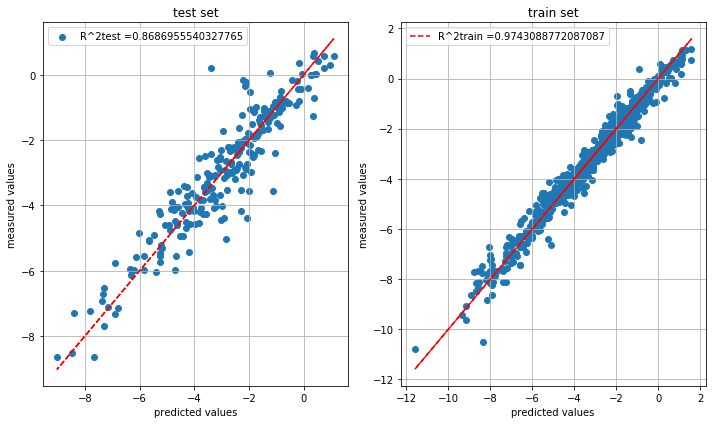

In [102]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
axes[0].scatter(y_test, Y_pred,label="R^2test ="+str(r2_score(y_test,Y_pred)))
axes[0].plot(y_test,y_test,'r--')
axes[0].legend()
axes[0].set(title = "test set",
       xlabel = "predicted values",
       ylabel = "measured values")
axes[0].grid(True)
axes[1].scatter(y_train, Y_pred2)
axes[1].plot(y_train,y_train,'r--',label="R^2train ="+str(r2_score(y_train,Y_pred2)))
axes[1].set(title = "train set",
       xlabel = "predicted values",
       ylabel = "measured values")
axes[1].legend()
axes[1].grid(True)
fig.tight_layout()

In [80]:
def plot_loss(history):
  plt.plot(history.history['loss'], label='Training loss')
  plt.plot(history.history['val_loss'], label='val_loss')
  plt.xlabel('Epoch')
  plt.ylabel('Error')
  plt.title( 'Loss on training and validation data (Regularisation) ')
  plt.legend()
  plt.grid(True)

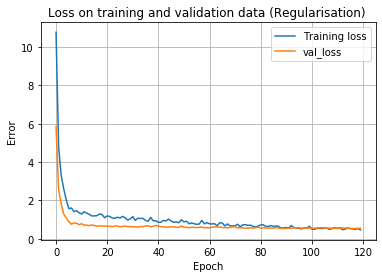

In [81]:
#plotting train and validation error vs epoch for the best model
model = Sequential([
  Dense(len(X_train[0]), activation='relu'),
  Dropout(0.2),
  Dense(8, activation='relu'),
  Dropout(0.2),
  Dense(1,activation='linear')])
# Compile the model.
model.compile(optimizer=Adam(learning_rate=0.001),loss='mean_squared_error')

history = model.fit(
  X_train,
  y_train,
  epochs=120,
  batch_size=16,
  validation_data = (X_test,y_test),verbose=0
)

plot_loss(history)